## Imports

In [1]:
import os

import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
from catboost import CatBoostRegressor
from lightgbm.sklearn import LGBMRegressor
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyRegressor
from sklearn.feature_selection import RFE, RFECV, SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, Ridge, RidgeCV
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    ShuffleSplit,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    PolynomialFeatures,
    StandardScaler,
)
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeRegressor, export_graphviz

alt.data_transformers.disable_max_rows()
alt.renderers.enable("mimetype")
alt.data_transformers.enable("data_server")

DataTransformerRegistry.enable('data_server')

## Data split

In [2]:
df = pd.read_csv("../data/processed/clean_data.csv").dropna()
df.shape
df.head()
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

X_train, y_train = train_df.drop(columns=["bloom_doy"]), train_df["bloom_doy"]
X_test, y_test = test_df.drop(columns=["bloom_doy"]), test_df["bloom_doy"]

## Preprocessing and transformations

In [3]:
categorical_features = ["country", "city"]
numeric_features = [
    "lat",
    "long",
    "alt",
    "tmax",
    "tmin",
    "prcp",
    "agdd_winter",
    "tmax_winter",
    "prcp_winter",
    "co2_percapita",
    "co2_emission",
]
drop_features = ["year"]
target = "bloom_doy"

In [4]:
scaler = StandardScaler()
enc = OneHotEncoder(handle_unknown="ignore", sparse=False)

preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),  # scaling on numeric features
    (
        OneHotEncoder(handle_unknown="ignore"),
        categorical_features,
    ),  # OHE on categorical features
    ("drop", drop_features),  # drop features
)

preprocessor.fit_transform(X_train).shape

(4327, 120)

In [5]:
results = {}  # dictionary to store all the results

In [6]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """
    scores = cross_validate(model, X_train, y_train, **kwargs)
    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []
    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))
    return pd.Series(data=out_col, index=mean_scores.index)

In [7]:
# make a scorer function that we can pass into cross-validation


def mape(true, pred):
    return 100.0 * np.mean(np.abs((pred - true) / true))


mape_scorer = make_scorer(mape, greater_is_better=False)

In [8]:
scoring_metrics = {
    "neg_RMSE": "neg_root_mean_squared_error",
    "r2": "r2",
    "mape": mape_scorer,
}

## Models

In [9]:
# making pipelines for all the regressor models and storing in "models" dictionary
models = {
    "Baseline": make_pipeline(preprocessor, DummyRegressor()),
    "Ridge": make_pipeline(preprocessor, Ridge(random_state=123)),
    "Lasso": make_pipeline(preprocessor, Lasso(random_state=123)),
    "Decision Tree": make_pipeline(
        preprocessor, DecisionTreeRegressor(random_state=123)
    ),
    "CatBoost": make_pipeline(
        preprocessor, CatBoostRegressor(verbose=0, random_state=123)
    ),
    "LGBM": make_pipeline(preprocessor, LGBMRegressor(random_state=123)),
    "LGBM+L1": make_pipeline(
        preprocessor,
        SelectFromModel(Lasso(alpha=0.01, max_iter=100000)),
        LGBMRegressor(random_state=123),
    ),
    "Support Vector": make_pipeline(preprocessor, SVR(epsilon=0.2)),
    "KNN": make_pipeline(
        preprocessor,
        KNeighborsRegressor(n_neighbors=30, weights="uniform", algorithm="auto"),
    ),
}

## Cross validation

In [10]:
# saving the mean cross validation scores in resutls dictionary created previously
for model_name, model in models.items():
    results[model_name] = mean_std_cross_val_scores(
        model,
        X_train,
        y_train,
        scoring=scoring_metrics,
        return_train_score=True,
    )

In [11]:
pd.DataFrame(results).rename(
    index={"test_neg RMSE": "cv_neg_RMSE", "test_r2": "cv_r2", "test_mape": "cv_mape"}
).drop(["fit_time", "score_time"])

,Baseline,Ridge,Lasso,Decision Tree,CatBoost,LGBM,LGBM+L1,Support Vector,KNN
test_neg_RMSE,-21.795 (+/- 1.233),-5.781 (+/- 0.225),-9.869 (+/- 0.400),-6.500 (+/- 0.323),-4.252 (+/- 0.075),-4.271 (+/- 0.101),-4.299 (+/- 0.092),-9.266 (+/- 0.850),-6.888 (+/- 0.287)
train_neg_RMSE,-21.806 (+/- 0.312),-5.552 (+/- 0.042),-9.820 (+/- 0.068),0.000 (+/- 0.000),-2.592 (+/- 0.027),-2.784 (+/- 0.027),-2.771 (+/- 0.032),-9.095 (+/- 0.098),-6.639 (+/- 0.113)
cv_r2,-0.003 (+/- 0.002),0.929 (+/- 0.009),0.794 (+/- 0.008),0.910 (+/- 0.010),0.962 (+/- 0.004),0.961 (+/- 0.004),0.961 (+/- 0.004),0.819 (+/- 0.013),0.899 (+/- 0.011)
train_r2,0.000 (+/- 0.000),0.935 (+/- 0.002),0.797 (+/- 0.003),1.000 (+/- 0.000),0.986 (+/- 0.000),0.984 (+/- 0.001),0.984 (+/- 0.000),0.826 (+/- 0.004),0.907 (+/- 0.004)
cv_mape,-21.041 (+/- 2.937),-5.116 (+/- 0.418),-9.745 (+/- 1.072),-5.193 (+/- 0.596),-3.635 (+/- 0.340),-3.600 (+/- 0.354),-3.619 (+/- 0.365),-8.964 (+/- 1.469),-5.962 (+/- 0.649)
train_mape,-21.031 (+/- 0.605),-4.934 (+/- 0.093),-9.696 (+/- 0.216),0.000 (+/- 0.000),-2.328 (+/- 0.047),-2.421 (+/- 0.058),-2.417 (+/- 0.058),-8.716 (+/- 0.247),-5.735 (+/- 0.162)


## Hyperparameter Optimization

In [13]:
# CatBoost
cb_param_grid = {
    "catboostregressor__max_depth": np.arange(1, 40),
    "catboostregressor__n_estimators": np.arange(5, 120),
}

cb_rand = RandomizedSearchCV(
    models["CatBoost"],
    cb_param_grid,
    n_iter=20,
    verbose=1,
    n_jobs=-1,
    random_state=123,
    return_train_score=True,
)
cb_random_search = cb_rand.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits



55 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
55 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\alexx\miniconda3\envs\573\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\alexx\miniconda3\envs\573\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\alexx\miniconda3\envs\573\lib\site-packages\catboost\core.py", line 5299, in fit
    return self._fit(X, y, cat_features, None, None, None, sample_weight, None, None, None, None, baseline,
  File "C:\Users\alexx\miniconda3\env

In [14]:
print("Best hyper-params for CatBoost:\n", cb_random_search.best_params_)

print("\nTraining and validation scores of Light GBM with the best hyper-params:")
pd.DataFrame(cb_random_search.cv_results_)[
    [
        "mean_train_score",
        "mean_test_score",
        "param_catboostregressor__max_depth",
        "param_catboostregressor__n_estimators",
        "rank_test_score",
    ]
].sort_values(by=['rank_test_score']).drop('rank_test_score', axis=1).head(1)

Best hyper-params for CatBoost:
 {'catboostregressor__n_estimators': 86, 'catboostregressor__max_depth': 12}

Training and validation scores of Light GBM with the best hyper-params:


,mean_train_score,mean_test_score,param_catboostregressor__max_depth,param_catboostregressor__n_estimators
2,0.994065,0.956585,12,86


In [15]:
# LightGBM
lgbm_param_grid = {
    "lgbmregressor__max_depth": np.arange(1, 40),
    "lgbmregressor__n_estimators": np.arange(5, 120),
}

lgbm_rand = RandomizedSearchCV(
    models["LGBM"],
    lgbm_param_grid,
    n_iter=20,
    verbose=1,
    n_jobs=-1,
    random_state=123,
    return_train_score=True,
)
lgbm_random_search = lgbm_rand.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [16]:
print("Best hyper-params for Light GBM:\n", lgbm_random_search.best_params_)

print("\nTraining and validation scores of Light GBM with the best hyper-params:")
pd.DataFrame(lgbm_random_search.cv_results_)[
    [
        "mean_train_score",
        "mean_test_score",
        "param_lgbmregressor__max_depth",
        "param_lgbmregressor__n_estimators",
        "rank_test_score",
    ]
].sort_values(by=['rank_test_score']).drop('rank_test_score', axis=1).head(1)

Best hyper-params for Light GBM:
 {'lgbmregressor__n_estimators': 110, 'lgbmregressor__max_depth': 29}

Training and validation scores of Light GBM with the best hyper-params:


,mean_train_score,mean_test_score,param_lgbmregressor__max_depth,param_lgbmregressor__n_estimators
13,0.984888,0.961734,29,110


## Feature Importance

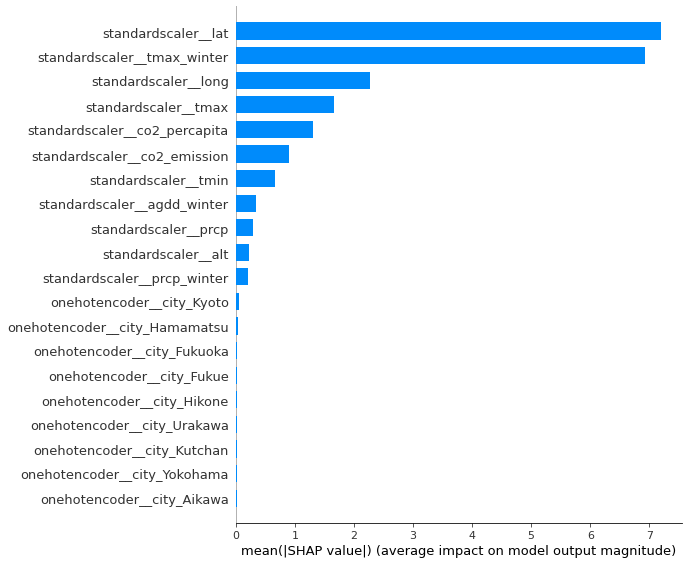

In [17]:
# Fit the preprocessor first
preprocessor.fit(X_train, y_train)

# Get all feature names
feature_names = preprocessor.get_feature_names_out()

# Create encoded train data
X_train_enc = pd.DataFrame(
    data=preprocessor.transform(X_train).toarray(),
    columns=feature_names,
    index=X_train.index,
)
X_train_enc.head()

# Fit regressor model using LGBMRegressor
pipe_lgbm = make_pipeline(preprocessor, LGBMRegressor(n_estimators = 110, max_depth = 29, random_state=123))
pipe_lgbm.fit(X_train, y_train)

# Create feature importance visualization using shap
lgbm_explainer = shap.TreeExplainer(pipe_lgbm.named_steps["lgbmregressor"])
train_lgbm_shap_values = lgbm_explainer.shap_values(X_train_enc)
shap.summary_plot(train_lgbm_shap_values, X_train_enc, plot_type="bar")

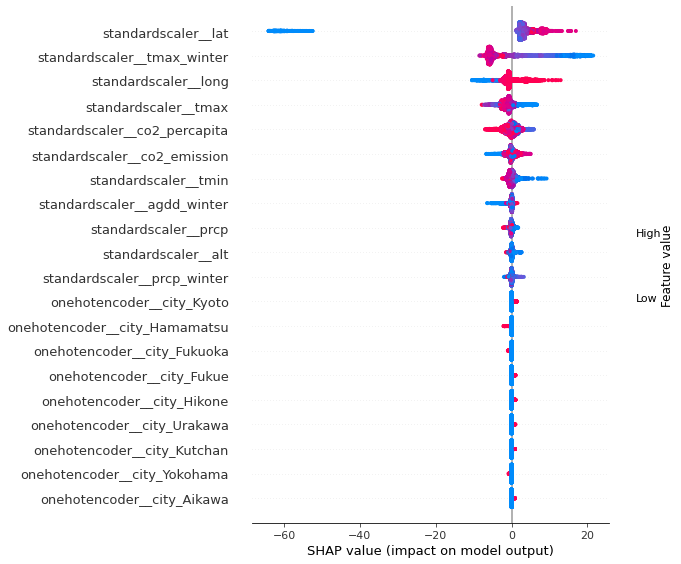

In [18]:
shap.summary_plot(train_lgbm_shap_values, X_train_enc)

## Test

In [19]:
# Predict on the test data and report scores
y_pred = pipe_lgbm.predict(X_test)
test_scores = {"metrics": list(scoring_metrics.keys()), "best model-lgbm": []}
test_scores["best model-lgbm"].append(
    -1 * mean_squared_error(y_test, y_pred, squared=False)
)
test_scores["best model-lgbm"].append(r2_score(y_test, y_pred))
test_scores["best model-lgbm"].append(mape(y_test, y_pred))
pd.DataFrame(test_scores).set_index("metrics")

,best model-lgbm
metrics,
neg_RMSE,-4.059999
r2,0.968617
mape,3.283192


In [24]:
# Create encoded test data
X_test_enc = pd.DataFrame(
    data=preprocessor.transform(X_test).toarray(),
    columns=feature_names,
    index=X_test.index,
)

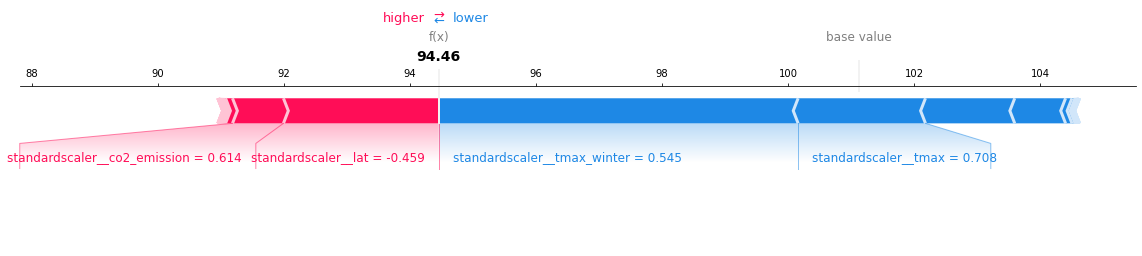

In [30]:
# We are only extracting shapely values for the first 5 test examples for speed.
test_lgbm_shap_values = lgbm_explainer.shap_values(X_test_enc[:5])

# Round off feature values for better display
X_train_enc = X_train_enc.round(3)
X_test_enc = X_test_enc.round(3)

# An example
shap.force_plot(
    lgbm_explainer.expected_value,
    test_lgbm_shap_values[4],
    X_test_enc.iloc[4, :],
    matplotlib=True,
)

In [31]:
print("True popularity for case one:", y_test.iloc[4])

True popularity for case one: 92
